In [1]:
#installs
!pip install xlrd
!pip install uncertainties

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.4/98.4 kB 2.9 MB/s eta 0:00:00


In [2]:
#imports
import pandas as pd
import numpy as np
from uncertainties import unumpy as unp
from uncertainties import ufloat
from uncertainties.umath import *
import math
import scipy as sc
import matplotlib.pyplot as plt
from scipy import optimize
from numpy import arange
from numpy.ma.core import tan
from scipy.optimize import curve_fit
import csv

In [3]:
#methods
def daten_fitten(funct, x_data, y_data, genauigkeit, p): #Step4/5
    #fiten
    pars, cov = curve_fit(f=funct, xdata=x_data, ydata=y_data, p0=p, bounds=[-np.inf, np.inf], maxfev=500000)
    # Get the standard deviations of the parameters (square roots of the diagonal of the covariance)
    stdevs = np.sqrt(np.diag(cov))
    print('Fitparameter')
    print(pars)
    print('zugehörige Uncertainty')
    print(stdevs)
    #datensets
    xfit = np.linspace(min(x_data), max(x_data), genauigkeit)
    yfit = funct(xfit, *pars)
    return pars, stdevs, xfit, yfit

def line(x, a, b):
  return a*x + b

In [4]:
# Daten einlesen
data = pd.read_excel('iron_line_list_.xlsx')

# Entferne alle Zeilen, die einen leeren Eintrag enthalten
data = data.dropna()

# Teilen der Werte in den Spalten 1 und 4 durch 1000
data.iloc[:, [0, 3, 4]] = data.iloc[:, [0, 3, 4]] / 1000

# Entferne alle Zeilen, bei denen der Wert in der dritten Spalte (Spaltenindex 2) größer als 10 ist
data = data[np.abs(data.iloc[:, 2]) <= 10]

# Entferne alle Zeilen, bei denen der Wert in der dritten Spalte (Spaltenindex 2) größer als 10 ist
data = data[np.abs(data.iloc[:, 1]) <= 10]

# Speichern der modifizierten Daten in einer neuen Excel-Datei (optional)
data.to_excel('iron_line_list_modifiziert.xlsx', index=False)

# Zeige die ersten Zeilen des modifizierten DataFrame an
print(data)

     Wavelenght (lab)  Exc. Potential  loggf    Lambda  Breite
0            5434.524           1.011 -2.122  5434.517   0.160
1            5424.068           4.320  0.520  5424.055   0.155
6            5049.820           2.279 -1.355  5049.804   0.139
10           6393.601           2.433 -1.432  6393.605   0.120
15           5194.942           1.557 -2.090  5194.926   0.113
..                ...             ...    ...       ...     ...
200          5849.684           3.694 -2.990  5849.680   0.005
201          6793.256           4.584 -4.275  6793.249   0.006
202          5677.685           4.103 -2.700  5677.678   0.003
203          5853.148           1.485 -5.280  5853.135   0.005
204          5552.694           4.955 -1.990  5552.680   0.007

[130 rows x 5 columns]


In [5]:
#Daten einlesen
data = pd.read_excel('iron_line_list_modifiziert.xlsx')

#converte dataframe to array
data = data.values

#schauen ob der unterschied zwischen den wellenlängen wo das maximum sein sollte und wo es durch den fit war größer als 0,15A ist
for i in range(0,len(data)):
    if abs(data[i,0] - data[i,3]) > 0.15:
      print(i)
      print(data[i])


59
[ 5.927789e+03  4.652000e+00 -1.090000e+00  6.597546e+03  3.700000e-02]
98
[ 6.311050e+03  2.831000e+00 -3.141000e+00  6.311491e+03  2.300000e-02]


In [6]:
#breite/EW soll kleiner als 0.12 sein
data_thin = []
condition = data[:, 4] < 0.12
data_thin = data[condition]

print(len(data_thin))
print(len(data))
#print(data)

126
130


Steigung: -0.7320+/-0.0024


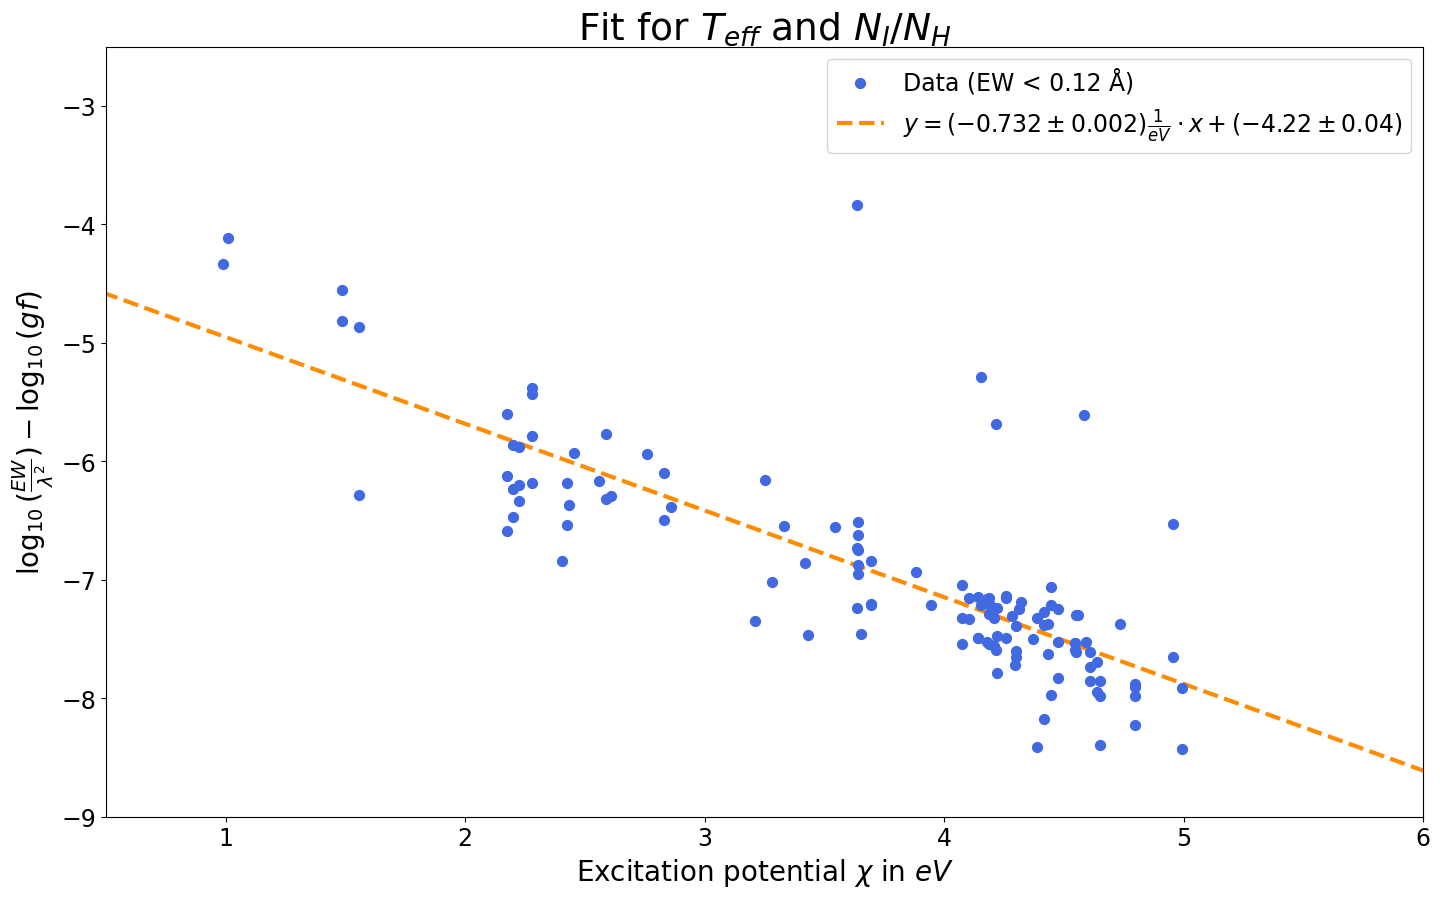

In [7]:
plt.subplots(1,1,figsize=(17, 10));

erg = np.zeros(len(data_thin))
for i in range(len(data_thin)):
    erg[i] = math.log10(data_thin[i,4]/pow(data_thin[i,3],2)) - data_thin[i,2]


data_thin = np.column_stack((data_thin, erg))

y = [i[5] for i in data_thin] #erg
x = [i[1] for i in data_thin] #Exc. Potential


plt.scatter(x, y, label = 'Data (EW < 0.12 Å)', color='royalblue', s=50, zorder= 5)



popt, pcov = sc.optimize.curve_fit(line, x, y)
a, b = popt
x_line = arange(-5, 3000)
y_line = line(x_line, a, b)
perr = np.diag(pcov)
steigung = ufloat(popt[0], pcov[0][0])
Schnitt = ufloat(popt[1], pcov[1][1])

plt.plot(x_line, y_line, '--', color='darkorange', linewidth=3, label = r'$y = (%.3f \pm %.3f)\frac{1}{eV} \cdot x + (%.2f \pm %.2f)$'%(steigung.nominal_value, steigung.std_dev, Schnitt.nominal_value, Schnitt.std_dev))
print('Steigung:', steigung)


# Add axis labels and a title
plt.xlabel(r'Excitation potential $\chi$ in $eV$', fontsize=20)
plt.ylabel(r'$\log_{10}(\frac{EW}{\lambda ^2}) - \log_{10}(gf)$', fontsize=20)
plt.title(r'Fit for $T_{eff}$ and $N_I/N_H$', fontsize=27)
plt.xticks(fontsize=17)
plt.yticks(fontsize=17)

# Display the plot
plt.legend(loc = 'upper right', fontsize=17)
plt.axis([0.5, 6, -9, -2.5])
plt.show()



In [8]:
T_eff = -5040/steigung
print(T_eff)

Ratio = 10 ** Schnitt
print(Ratio)

6885+/-23
(6.0+/-0.5)e-05


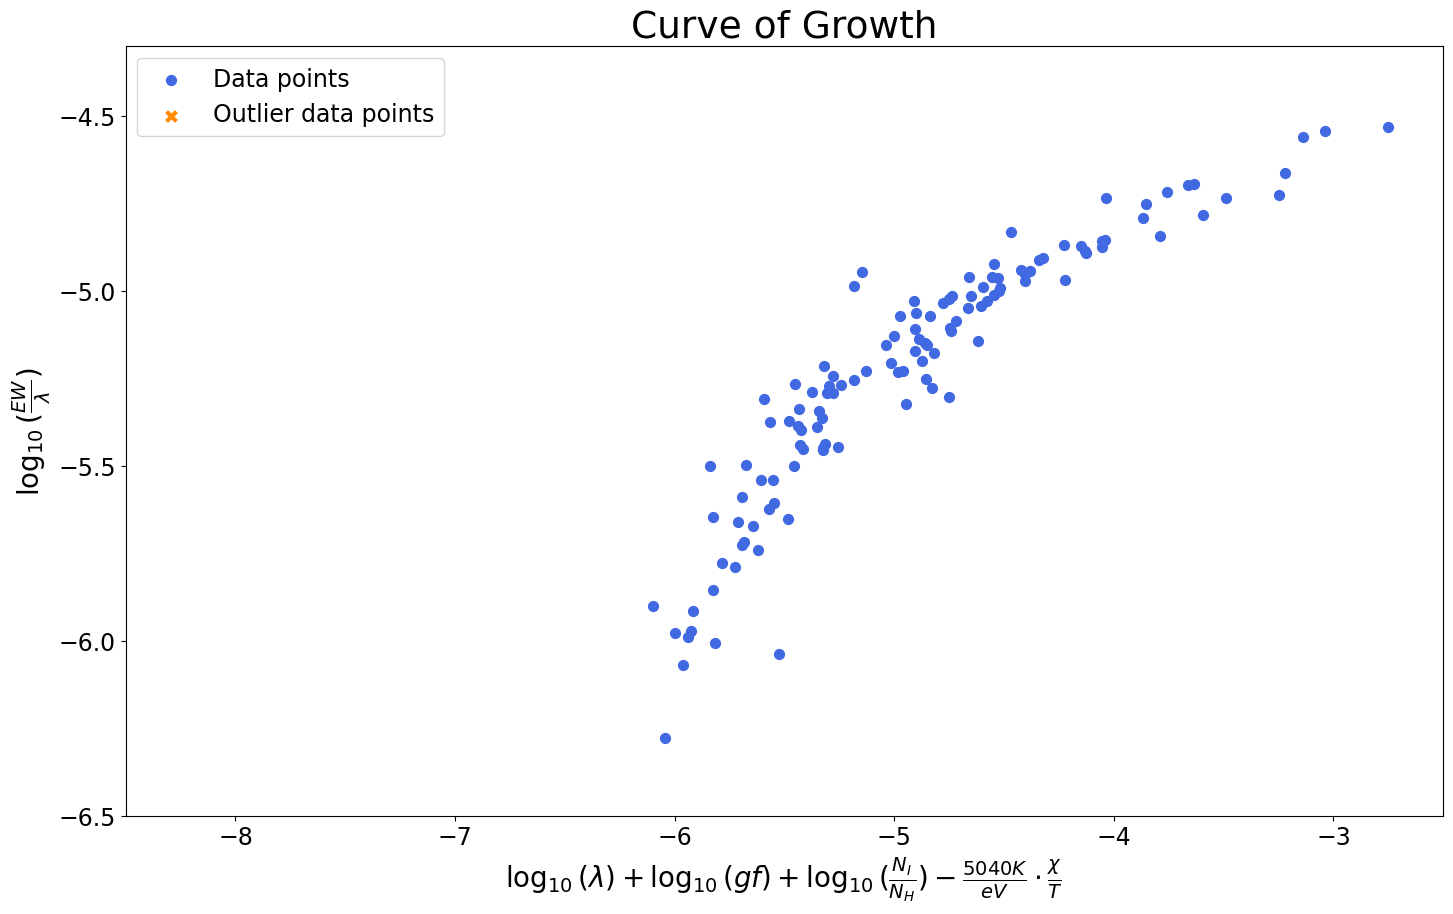

In [18]:
from matplotlib.ticker import MultipleLocator

plt.subplots(1,1,figsize=(17, 10));

uncertainty_array = np.zeros(len(data))
erg = np.zeros(len(data))
erg = unp.uarray(erg, uncertainty_array)


for i in range(len(data)):
    erg[i] = math.log10(data[i,4]/data[i,3])

data = np.column_stack((data, erg))

uncertainty_array = np.zeros(len(data))
erg = np.zeros(len(data))
erg = unp.uarray(erg, uncertainty_array)

for i in range(len(data)):
    erg[i] = math.log10(data[i,3])+data[i,2]+Schnitt-5040*data[i,1]/T_eff

data = np.column_stack((data, erg))

data_trash = []
condition = data[:, -1] < -6.2
data_trash = data[condition]

condition1 = data[:, -1] > -6.2
data = data[condition1]

y = [i[-2] for i in data]
x = [float(i[-1].nominal_value) for i in data]

y2 = [i[-2] for i in data_trash]
x2 = [float(i[-1].nominal_value) for i in data_trash]

plt.scatter(x, y, label = 'Data points', color='royalblue', s=50, zorder= 5)
plt.scatter(x2, y2, label = 'Outlier data points', marker ='x', color='darkorange', s=50, zorder= 5, linewidths=3)


popt, pcov = sc.optimize.curve_fit(line, x, y)
a, b = popt
x_line = arange(-5, 3000)
y_line = line(x_line, a, b)
perr = np.diag(pcov)
steigung = ufloat(popt[0], pcov[0][0])
Schnitt = ufloat(popt[1], pcov[1][1])



# Add axis labels and a title  - \dfrac{5040}{T} \chi + log_{10} \biggl(\dfrac{N_I}{N_H} \biggr)
plt.xlabel(r'$\log_{10}(\lambda) + \log_{10}(gf) + \log_{10}({\frac{N_{I}}{N_{H}}) - \frac{5040K}{eV} \cdot \frac{\chi}{T}}$', fontsize=20)
plt.ylabel(r'$\log_{10}(\frac{EW}{\lambda})$', fontsize=20)
plt.title('Curve of Growth', fontsize=27)
plt.xticks(fontsize=17)
plt.yticks(fontsize=17)
plt.gca().yaxis.set_major_locator(MultipleLocator(0.5))

# Display the plot
plt.legend(loc = 'upper left', fontsize=17)
plt.axis([-8.5, -2.5, -6.5, -4.3])
plt.show()

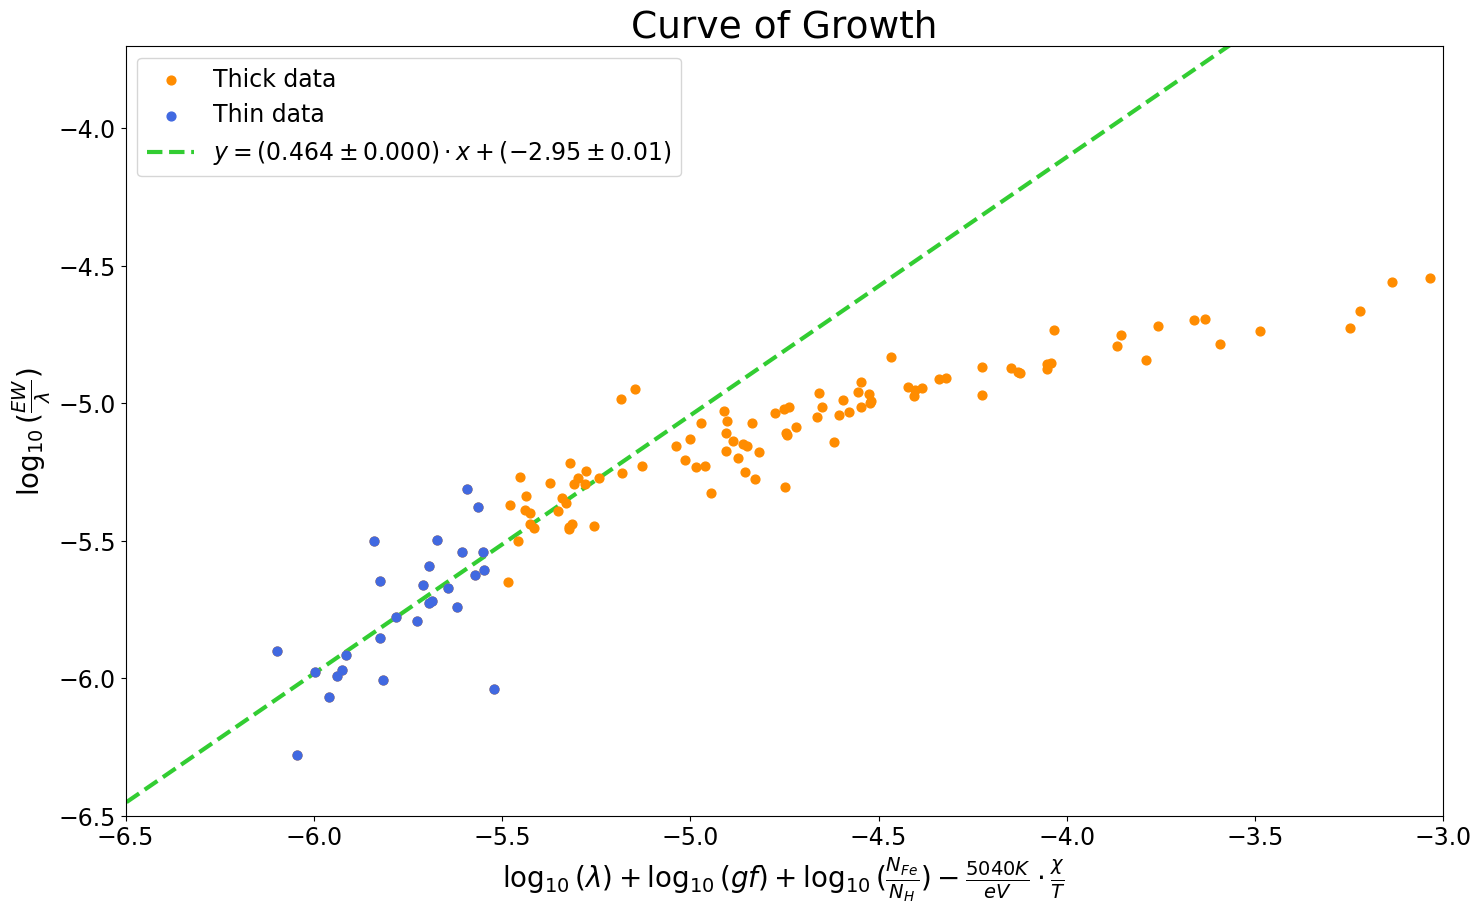

In [19]:
plt.subplots(1,1,figsize=(17, 10));

# Extrahiere x- und y-Werte für alle Datenpunkte
y_all = [i[-2] for i in data]
x_all = [float(i[-1].nominal_value) for i in data]

# Scatterplot aller Datenpunkte
plt.scatter(x_all, y_all, label = 'Thick data', color='darkorange', s=40, zorder= 5)

# Selektiere die "thin data"
condition = data[:, -1] < -5.5
data_thin = data[condition]

# Extrahiere x- und y-Werte für die "thin data"
y_thin = [i[-2] for i in data_thin]
x_thin = [float(i[-1].nominal_value) for i in data_thin]

# Scatterplot der "thin data"
plt.scatter(x_thin, y_thin, label='Thin data', color='royalblue', s=40, zorder=5)

# Führe eine lineare Regression auf den "thin data" durch
popt, pcov = sc.optimize.curve_fit(line, x_thin, y_thin)

# Extrahiere die Parameter der linearen Regression
a, b = popt

# Definiere den Bereich für die x-Werte der Fitting-Linie
x_line = np.arange(-10, 0)

# Berechne die y-Werte der Fitting-Linie
y_line = line(x_line, a, b)

# Plotte die Fitting-Linie
plt.plot(x_line, y_line, '--', color='limegreen', linewidth=3, label = r'$y = (%.3f \pm %.3f)\cdot x + (%.2f \pm %.2f)$'%(steigung.nominal_value, steigung.std_dev, Schnitt.nominal_value, Schnitt.std_dev))

# Addiere Achsenbeschriftungen, Titel und Legende
plt.xlabel(r'$\log_{10}(\lambda) + \log_{10}(gf) + \log_{10}(\frac{N_{Fe}}{N_{H}}) - \frac{5040K}{eV} \cdot \frac{\chi}{T}$', fontsize=20)
plt.ylabel(r'$\log_{10}(\frac{EW}{\lambda})$', fontsize=20)
plt.title('Curve of Growth', fontsize=27)
plt.xticks(fontsize=17)
plt.yticks(fontsize=17)
plt.legend(loc='upper left', fontsize=17)

# Display the plot
plt.legend(loc = 'upper left', fontsize=17)
plt.axis([-6.5, -3, -6.5, -3.7])
plt.show()

Steigung: -0.8848+/-0.0011


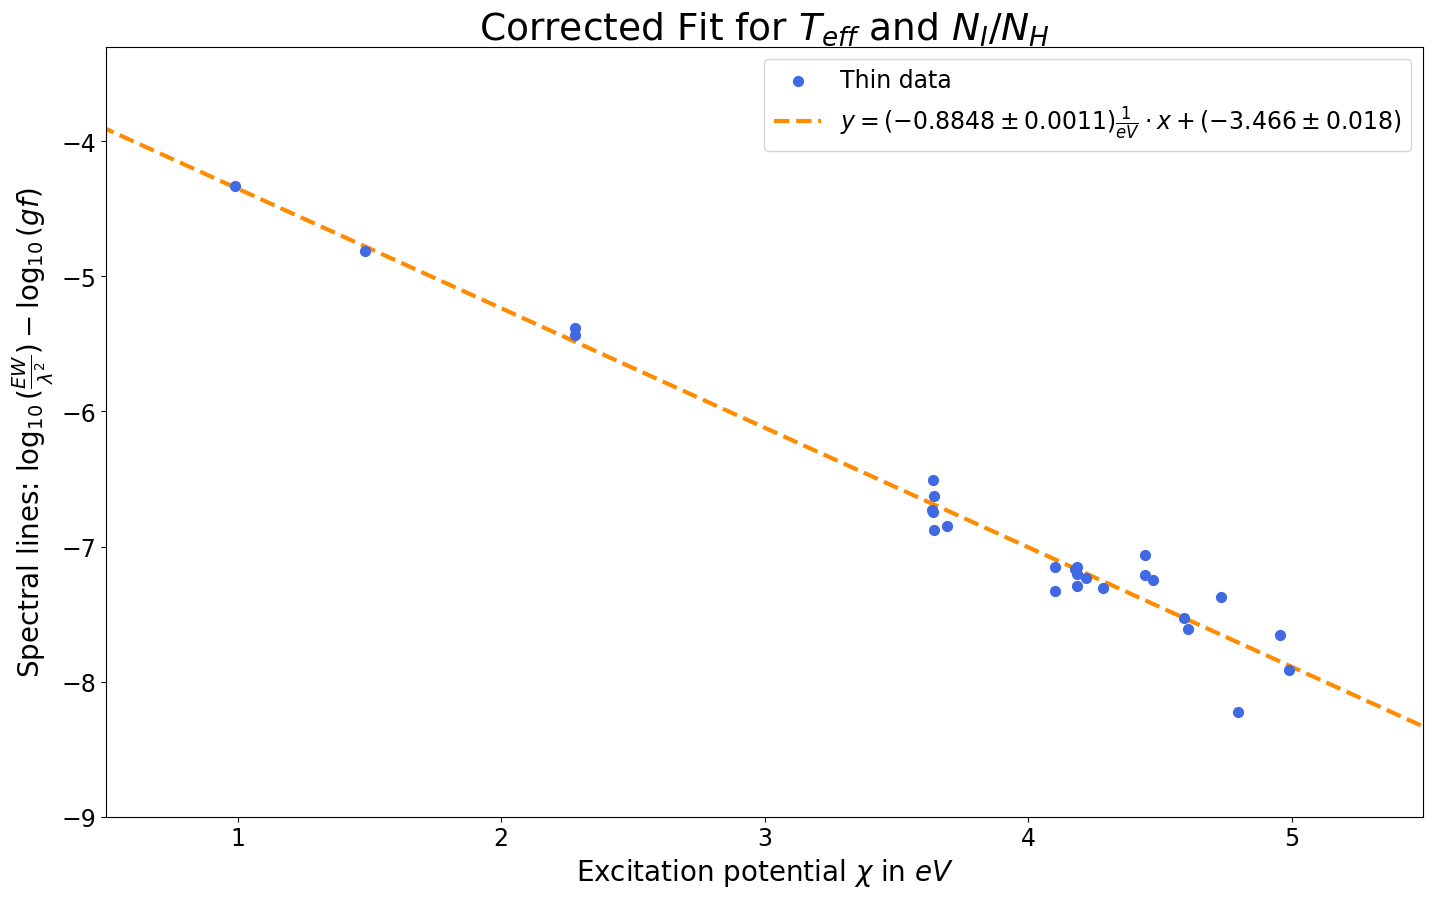

In [20]:
plt.subplots(1,1,figsize=(17, 10));

erg = np.zeros(len(data_thin))
for i in range(len(data_thin)):
    erg[i] = math.log10(data_thin[i,4]/pow(data_thin[i,3],2)) - data_thin[i,2]


data_thin = np.column_stack((data_thin, erg))

y = [i[-1] for i in data_thin]
x = [i[1] for i in data_thin]

plt.scatter(x, y, label = 'Thin data', color='royalblue', s=50, zorder= 5)



popt, pcov = sc.optimize.curve_fit(line, x, y)
a, b = popt
x_line = arange(-5, 3000)
y_line = line(x_line, a, b)
perr = np.diag(pcov)
steigung = ufloat(popt[0], pcov[0][0])
Schnitt = ufloat(popt[1], pcov[1][1])

plt.plot(x_line, y_line, '--', color='darkorange', linewidth=3, label = r'$y = (%.4f \pm %.4f)\frac{1}{eV} \cdot x + (%.3f \pm %.3f)$'%(steigung.nominal_value, steigung.std_dev, Schnitt.nominal_value, Schnitt.std_dev))
print('Steigung:', steigung)


# Add axis labels and a title
plt.xlabel(r'Excitation potential $\chi$ in $eV$', fontsize=20)
plt.ylabel(r'Spectral lines: $\log_{10}(\frac{EW}{\lambda ^2}) - \log_{10}(gf)$', fontsize=20)
plt.title('Corrected Fit for $T_{eff}$ and $N_I/N_H$', fontsize=27)
plt.xticks(fontsize=17)
plt.yticks(fontsize=17)

# Display the plot
plt.legend(loc = 'upper right', fontsize=17)
#plt.axis([-0.1, 6, -8.5, -3]) #Achsenanpassung
plt.axis([0.5, 5.5, -9, -3.3])
plt.show()


In [21]:
T_eff = -5040/steigung
print(T_eff)

Ratio = 10 ** Schnitt
print(Ratio)

5696+/-7
0.000342+/-0.000014


NameError: name 'data_thin_delete' is not defined

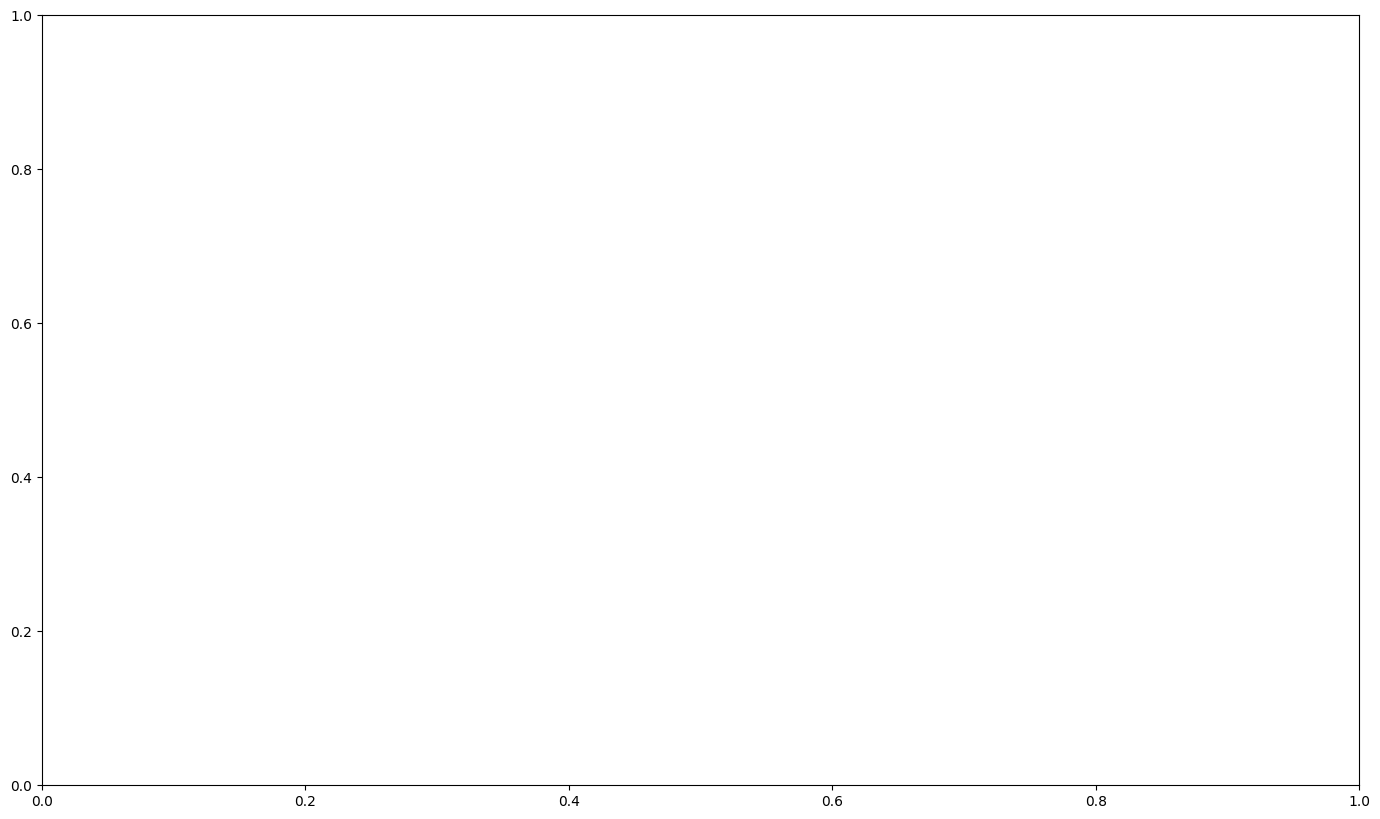

In [13]:
plt.subplots(1,1,figsize=(17, 10));

uncertainty_array = np.zeros(len(data_thin))
erg = np.zeros(len(data_thin))
erg = unp.uarray(erg, uncertainty_array)


for i in range(len(data_thin)):
    erg[i] = math.log10(data_thin[i,4]/data_thin[i,3])

data_thin = np.column_stack((data_thin, erg))

uncertainty_array = np.zeros(len(data_thin))
erg = np.zeros(len(data_thin))
erg = unp.uarray(erg, uncertainty_array)

for i in range(len(data_thin)):
    erg[i] = math.log10(data_thin[i,3])+data_thin[i,2]+Schnitt-5040*data_thin[i,1]/T_eff

data_thin = np.column_stack((data_thin, erg))


y = [i[-2] for i in data_thin]
x = [float(i[-1].nominal_value) for i in data_thin]

uncertainty_array = np.zeros(len(data_thin_delete))
erg = np.zeros(len(data_thin_delete))
erg = unp.uarray(erg, uncertainty_array)


for i in range(len(data_thin_delete)):
    erg[i] = math.log10(data_thin_delete[i,4]/data_thin_delete[i,3])

data_thin_delete = np.column_stack((data_thin_delete, erg))

uncertainty_array = np.zeros(len(data_thin_delete))
erg = np.zeros(len(data_thin_delete))
erg = unp.uarray(erg, uncertainty_array)

for i in range(len(data_thin_delete)):
    erg[i] = math.log10(data_thin_delete[i,3])+data_thin_delete[i,2]+Schnitt-5040*data_thin_delete[i,1]/T_eff

data_thin_delete = np.column_stack((data_thin_delete, erg))

y2 = [i[-2] for i in data_thin_delete]
x2 = [float(i[-1].nominal_value) for i in data_thin_delete]



plt.scatter(x, y, label = 'thin data', color='green', s=20, zorder= 5)
plt.scatter(x2, y2, label = 'thick data', marker='x', color='black', s=20, zorder= 5)


popt, pcov = sc.optimize.curve_fit(line, x, y)
a, b = popt
x_line = arange(-10, 0)
y_line = line(x_line, a, b)
perr = np.diag(pcov)
steigung = ufloat(popt[0], pcov[0][0])
Schnitt = ufloat(popt[1], pcov[1][1])

plt.plot(x_line, y_line, '--', color='red', label = r'$y = (%.3f \pm %.3f)\cdot x + (%.2f \pm %.2f)$'%(steigung.nominal_value, steigung.std_dev, Schnitt.nominal_value, Schnitt.std_dev))
print('Steigung:', steigung)



# Add axis labels and a title
plt.xlabel(r'$\log_{10}(\lambda) + \log_{10}(gf) + \log_{10}({\frac{N_{Fe}}{N_{H}}) - \frac{5040K}{eV} \cdot \frac{\chi}{T}}$', fontsize=20)
plt.ylabel(r'$\log_{10}(\frac{EW}{\lambda})$', fontsize=20)
plt.title('Standard Curve of Growth', fontsize=23)
plt.xticks(fontsize=17)
plt.yticks(fontsize=17)

# Display the plot
plt.legend(loc = 'upper left', fontsize=17)
plt.axis([-6.5, -3, -6.5, -3]) #Achsenanpassung
plt.show()